### Load Cleaned Dataset

In [25]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/processed/tokopedia_reviews_clean.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nSentiment distribution:")
print(df['sentiment']. value_counts())
print(f"\nSentiment proportion: ")
print(df['sentiment'].value_counts(normalize=True).round(3))
df. head()

Dataset shape: (607, 4)

Sentiment distribution:
sentiment
positive    560
negative     29
neutral      18
Name: count, dtype: int64

Sentiment proportion: 
sentiment
positive    0.923
negative    0.048
neutral     0.030
Name: proportion, dtype: float64


,review,clean_text,rating,sentiment
0,Beli starlight tp katane habis dikirim warna h...,beli starlight katane habis kirim warna hitam ...,1,negative
1,"Dapat barang minus di layar, seperti ada kilat...",barang minus layar kilat buka kunci pas aju ko...,1,negative
2,Kondisi segel nya udah kebuka gatau ini ori ap...,kondisi segel nya udah buka gatau ori bkn new,1,negative
3,"saya udh nunggu garansi IBOX 1bulanan, hpnya g...",udh nunggu garansi ibox bulan hpnya gak selesa...,1,negative
4,Saya beli barangnya hilang di pengiriman (Ante...,beli barang hilang kirim anteraja status kirim...,1,negative


### Encode Labels

In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])

print("Label mapping:")
for idx, class_name in enumerate(le.classes_):
    print(f"{idx}: {class_name}")

print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

Label mapping:
0: negative
1: neutral
2: positive

Label distribution:
label
0     29
1     18
2    560
Name: count, dtype: int64


### Train–Test Split

In [27]:
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Training set size: 485
Test set size: 122

Training set distribution:
label
0     23
1     14
2    448
Name: count, dtype: int64

Test set distribution:
label
0      6
1      4
2    112
Name: count, dtype: int64


### Feature Extraction — TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Optimized parameters for small dataset
tfidf = TfidfVectorizer(
    max_features=1000,      # Reduced from 5000
    ngram_range=(1,2),      # Unigrams and bigrams
    min_df=2,               # Ignore terms that appear in less than 2 documents
    max_df=0.8              # Ignore terms that appear in more than 80% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

TF-IDF shape: (485, 1000)
Vocabulary size: 1000


### Handle Class Imbalance with SMOTE

In [29]:
from imblearn.over_sampling import SMOTE

print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

print("\nClass distribution after SMOTE:")
print(pd. Series(y_train_resampled).value_counts().sort_index())

Class distribution before SMOTE:
label
0     23
1     14
2    448
Name: count, dtype: int64

Class distribution after SMOTE:
label
0    448
1    448
2    448
Name: count, dtype: int64


### Logistic Regression with Hyperparameter Tuning

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [500, 1000],
    'class_weight': ['balanced', None]
}

# Grid search with cross-validation
lr = LogisticRegression(random_state=42)
grid_search = GridSearchCV(
    lr,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Performing grid search...")
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1-macro score: {grid_search.best_score_:.4f}")

# Use best model
model = grid_search.best_estimator_

Performing grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 500}
Best CV F1-macro score: 0.9851


### Cross-Validation Evaluation

In [31]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(
    model, 
    X_train_resampled, 
    y_train_resampled, 
    cv=5, 
    scoring='f1_macro'
)

print("=== Cross-Validation Results ===")
print(f"CV F1-Macro Scores: {cv_scores}")
print(f"Mean CV F1-Macro:  {cv_scores.mean():.4f}")
print(f"Std CV F1-Macro: {cv_scores.std():.4f}")

=== Cross-Validation Results ===
CV F1-Macro Scores: [0.97763454 0.98880496 0.99255098 0.98127809 0.98501049]
Mean CV F1-Macro:  0.9851
Std CV F1-Macro: 0.0053


### Test Set Evaluation — Logistic Regression

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

y_pred = model.predict(X_test_tfidf)

print("=== Logistic Regression - Test Set Results ===")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Macro: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1-Weighted: {f1_score(y_test, y_pred, average='weighted'):.4f}")

print("\n=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=le. classes_
))

=== Logistic Regression - Test Set Results ===

Accuracy: 0.9016
F1-Macro: 0.5891
F1-Weighted: 0.9047

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.50      0.67      0.57         6
     neutral       0.25      0.25      0.25         4
    positive       0.95      0.94      0.95       112

    accuracy                           0.90       122
   macro avg       0.57      0.62      0.59       122
weighted avg       0.91      0.90      0.90       122



#### Confusion Matrix — Logistic Regression

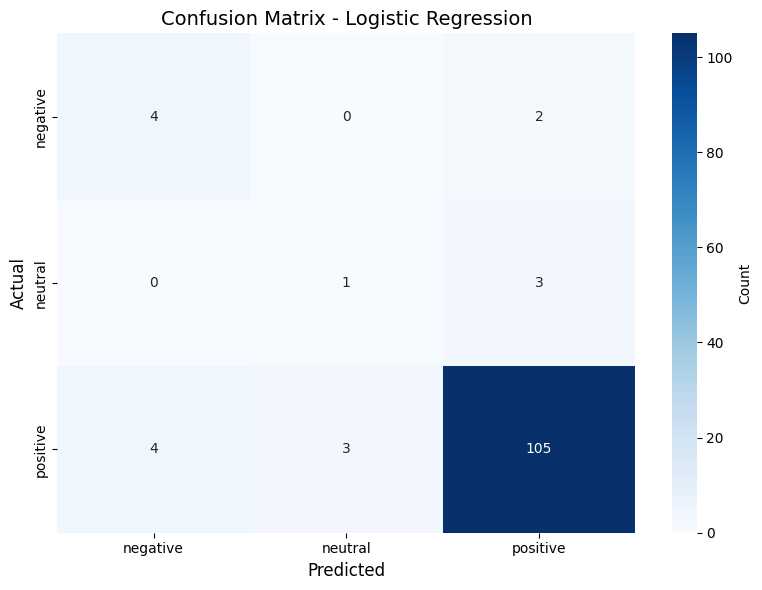

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - Logistic Regression", fontsize=14)
plt.tight_layout()
plt.show()

### Train Naive Bayes

In [34]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_pred_nb = nb_model.predict(X_test_tfidf)

print("=== Naive Bayes - Test Set Results ===")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"F1-Macro:  {f1_score(y_test, y_pred_nb, average='macro'):.4f}")
print(f"F1-Weighted: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

print("\n=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred_nb,
    target_names=le. classes_
))

=== Naive Bayes - Test Set Results ===

Accuracy: 0.8525
F1-Macro:  0.6016
F1-Weighted: 0.8809

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.67      0.67      0.67         6
     neutral       0.14      0.50      0.22         4
    positive       0.96      0.88      0.92       112

    accuracy                           0.85       122
   macro avg       0.59      0.68      0.60       122
weighted avg       0.92      0.85      0.88       122



### Evaluation Naive Bayes

In [35]:
y_pred_nb = nb_model.predict(X_test_tfidf)

print("=== Naive Bayes - Test Set Results ===")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"F1-Macro: {f1_score(y_test, y_pred_nb, average='macro'):.4f}")
print(f"F1-Weighted: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

print("\n=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred_nb,
    target_names=le.classes_
))

=== Naive Bayes - Test Set Results ===

Accuracy: 0.8525
F1-Macro: 0.6016
F1-Weighted: 0.8809

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.67      0.67      0.67         6
     neutral       0.14      0.50      0.22         4
    positive       0.96      0.88      0.92       112

    accuracy                           0.85       122
   macro avg       0.59      0.68      0.60       122
weighted avg       0.92      0.85      0.88       122



#### Confusion Matrix — Naive Bayes

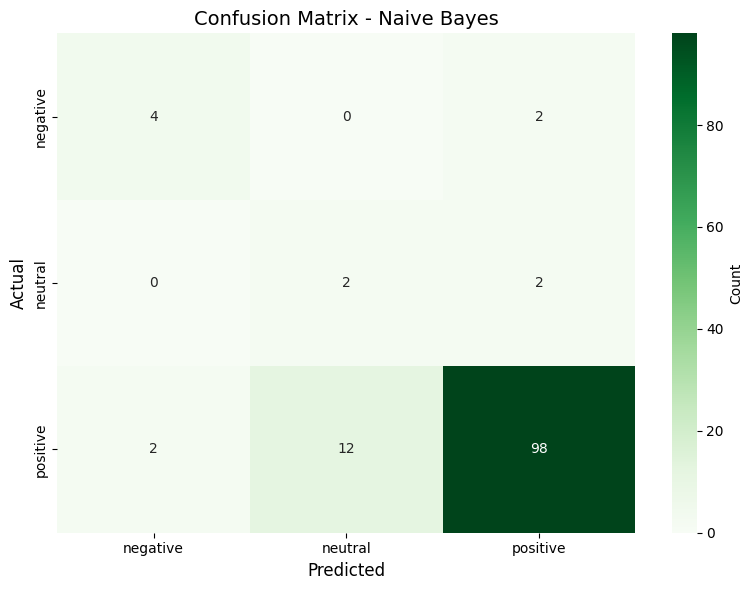

In [36]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - Naive Bayes", fontsize=14)
plt.tight_layout()
plt.show()

### Logistic Regression vs Naive Bayes

=== Model Comparison ===
                 Model  Accuracy  F1-Macro  F1-Weighted
0  Logistic Regression    0.9016    0.5891       0.9047
1          Naive Bayes    0.8525    0.6016       0.8809


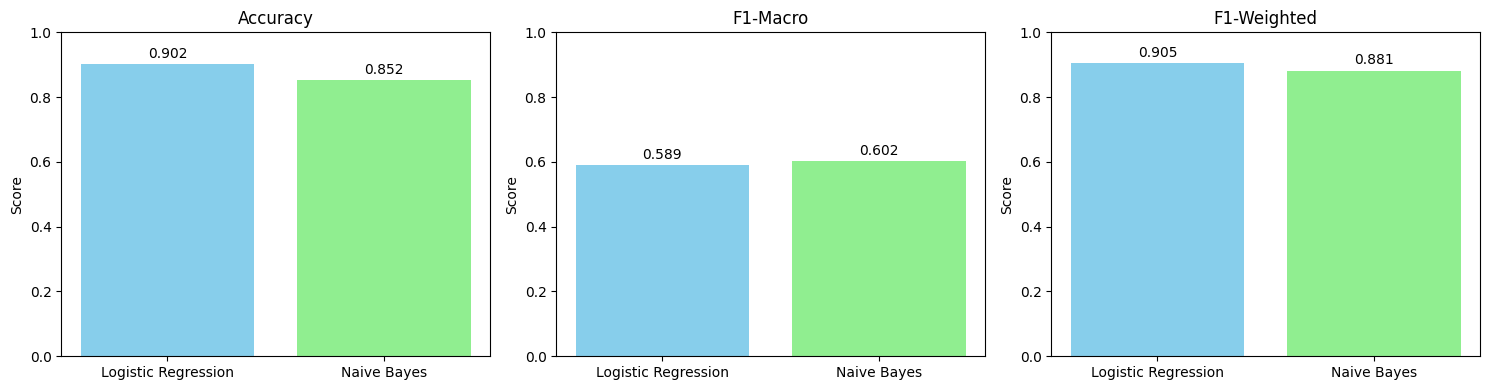

In [37]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes"],
    "Accuracy":  [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_nb)
    ],
    "F1-Macro": [
        f1_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred_nb, average="macro")
    ],
    "F1-Weighted": [
        f1_score(y_test, y_pred, average="weighted"),
        f1_score(y_test, y_pred_nb, average="weighted")
    ]
})

print("=== Model Comparison ===")
print(results. round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted']
for idx, metric in enumerate(metrics):
    axes[idx].bar(results['Model'], results[metric], color=['skyblue', 'lightgreen'])
    axes[idx].set_title(metric, fontsize=12)
    axes[idx].set_ylabel('Score', fontsize=10)
    axes[idx].set_ylim([0, 1])
    for i, v in enumerate(results[metric]):
        axes[idx].text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

plt. tight_layout()
plt.show()

### Feature Importance Analysis

In [38]:
feature_names = tfidf.get_feature_names_out()

# Get feature importance (coefficients) for each class
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'negative':  model.coef_[0],
    'neutral': model.coef_[1],
    'positive': model.coef_[2]
})

# Top 15 features per sentiment
print("=== Top 15 Features per Sentiment ===")
for sentiment in le.classes_:
    top_features = feature_importance. nlargest(15, sentiment)[
        ['feature', sentiment]
    ]
    print(f"\n{sentiment. upper()}:")
    print(top_features.to_string(index=False))

=== Top 15 Features per Sentiment ===

NEGATIVE:
     feature  negative
        ngga  1.734483
       layan  1.510989
        blok  1.498678
    tanggung  1.205129
        alas  1.142219
sesuai minta  1.116257
   toko jual  1.082077
       tulis  1.051445
        kalo  1.049184
      minggu  1.032392
proses kirim  1.030739
    komplain  1.022964
       biaya  1.003336
      cancel  0.986062
      device  0.976325

NEUTRAL:
    feature  neutral
 kode kirim 2.757942
      kurir 2.590324
     dateng 2.539306
      ujung 2.147465
request paa 1.882214
  paa kirim 1.768018
      kirim 1.764040
      kotor 1.753471
        paa 1.716541
        dus 1.609302
        bli 1.499627
      order 1.437498
   produksi 1.424165
      murah 1.360158
        sen 1.318712

POSITIVE:
      feature  positive
        cepat  1.775412
         aman  1.718469
       barang  1.713423
     original  1.563187
       seller  1.484538
  kirim cepat  1.389320
          ori  1.320393
         moga  1.303241
       man

### Visualize Top Features

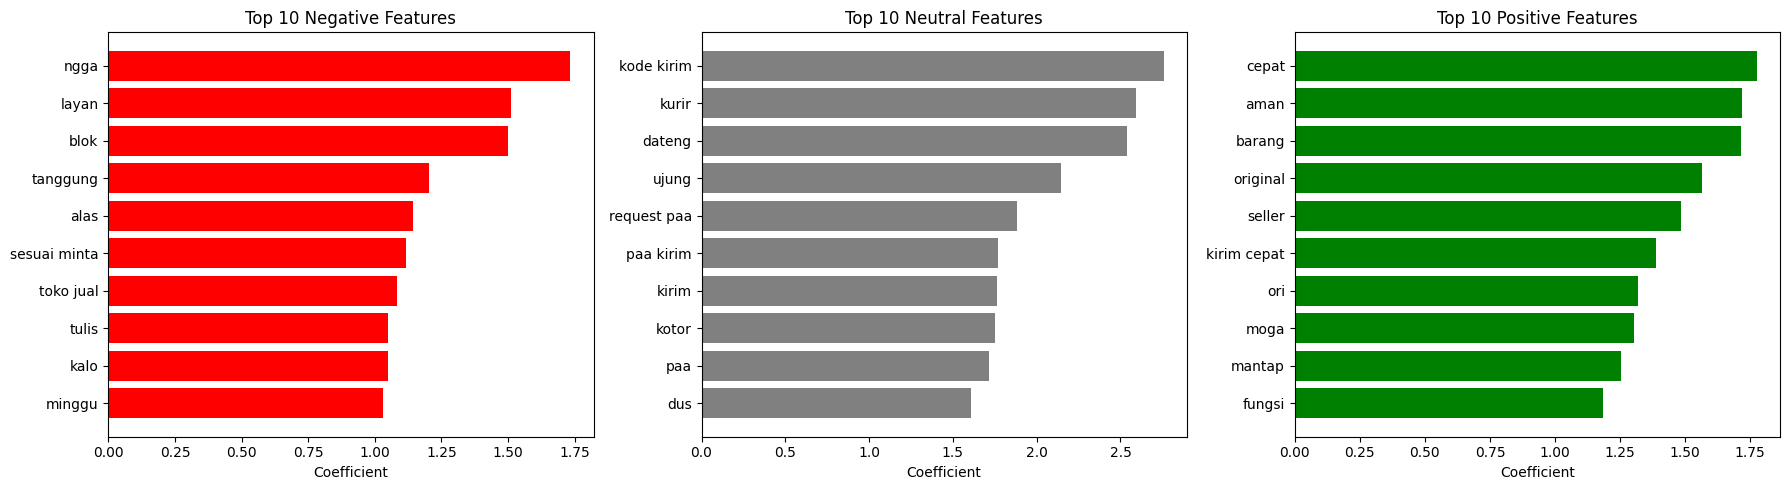

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, sentiment in enumerate(le. classes_):
    top_10 = feature_importance.nlargest(10, sentiment)
    axes[idx].barh(top_10['feature'], top_10[sentiment], color=['red', 'gray', 'green'][idx])
    axes[idx].set_title(f'Top 10 {sentiment. capitalize()} Features', fontsize=12)
    axes[idx].set_xlabel('Coefficient', fontsize=10)
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

### Save Best Model

In [45]:
import joblib

joblib.dump(model, '../models/logistic_regression_model.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
joblib.dump(le, '../models/label_encoder.pkl')

print("Model saved to:  ../models/logistic_regression_model.pkl")
print("Vectorizer saved to: ../models/tfidf_vectorizer.pkl")
print("Label encoder saved to: ../models/label_encoder.pkl")

Model saved to:  ../models/logistic_regression_model.pkl
Vectorizer saved to: ../models/tfidf_vectorizer.pkl
Label encoder saved to: ../models/label_encoder.pkl
